In [7]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [8]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

    #add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

   01 wt_0h 02 wt_2h 03 arm2db.14_0h 04 arm2db.14_2h 05 arm2db.19_0h
1 0.9771600 26.32925        0.941696        27.00700              NA
2 0.9976922 25.78741        1.002313        27.38400              NA
3 1.0257411 25.60928        1.059463        26.26849              NA
4 0.8705506 26.20787              NA              NA       1.0352649
5 1.1019051 26.02684              NA              NA       1.0281138
6 1.0424658 25.31513              NA              NA       0.9395227
  06 arm2db.19_2h 07 flg22_0h 08 flg22_2h   Group
1              NA   0.9614831    72.76947 Trial01
2              NA   0.9482460    71.76763 Trial01
3              NA   1.0968250    70.29068 Trial01
4        27.32081   1.0116194    71.43676 Trial01
5        27.13209   0.9976922    72.43398 Trial01
6        27.13209   0.9908006    71.93364 Trial01
# A tibble: 6 × 3
  ind             Group   values
  <chr>           <chr>    <dbl>
1 01 wt_0h        Trial01  0.977
2 02 wt_2h        Trial01 26.3  
3 03 arm2db.14_0h

# A tibble: 6 × 3
  Treatment Trial   VALUE
  <chr>     <chr>   <dbl>
1 01 wt_0h  Trial01 0.977
2 01 wt_0h  Trial01 0.998
3 01 wt_0h  Trial01 1.03 
4 01 wt_0h  Trial01 0.871
5 01 wt_0h  Trial01 1.10 
6 01 wt_0h  Trial01 1.04 


[1] 68 67

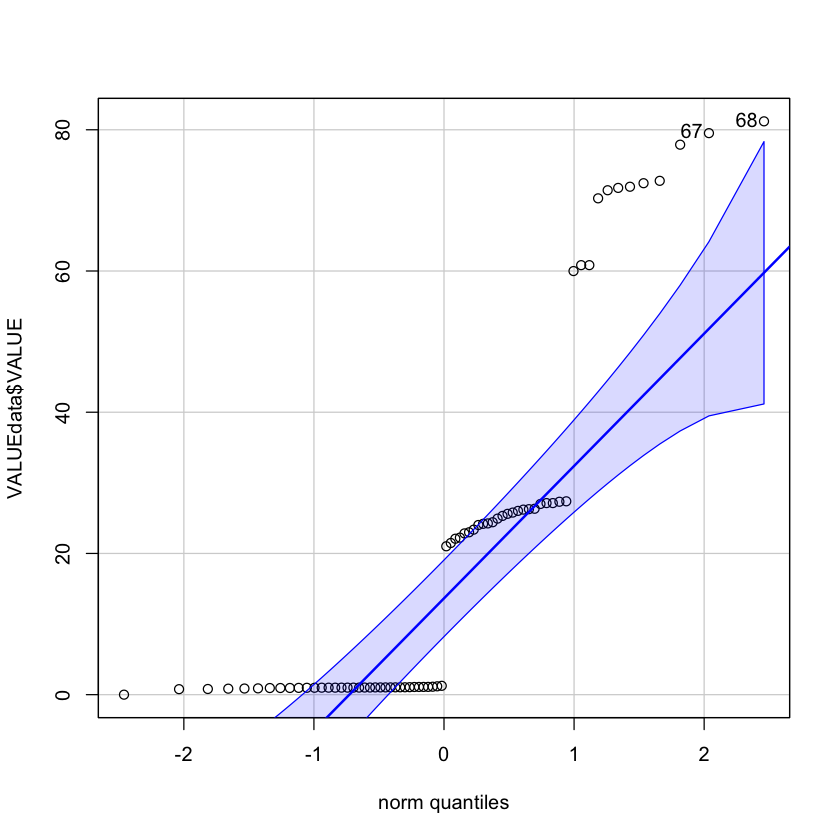

In [9]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
   380.1    402.9   -180.0    360.1       62 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6117 -0.1509  0.0514  0.1931  3.6521 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept) 0.2639   0.5137  
 Residual             8.5222   2.9193  
Number of obs: 72, groups:  Trial, 2

Fixed effects:
                         Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)               0.91803    0.91767 19.52067   1.000    0.329    
Treatment02 wt_2h        23.07608    1.19179 70.00000  19.363   <2e-16 ***
Treatment03 arm2db.14_0h  0.09083    1.45964 70.00000   0.062    0.951    
Treatment04 arm2db.14_2h 24.45774    1.45964 70.00000  16.756   <2e-16 ***
Treatment05 arm2db.19_0h  0.09026    1.45964 70.00000   0.062    0.951    
Tre

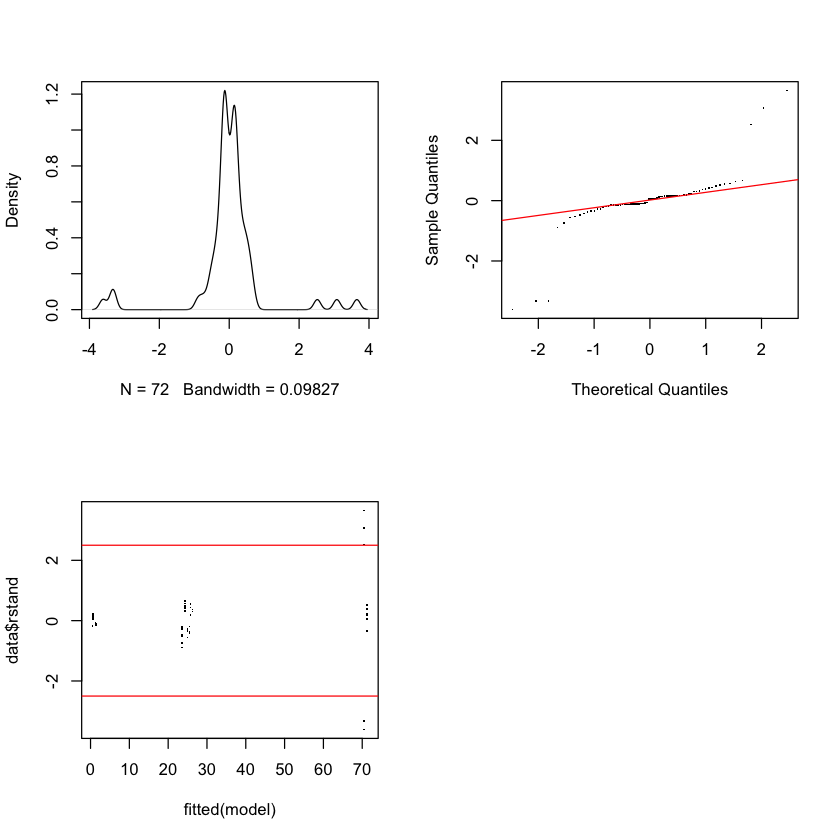

In [10]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [11]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq         NumDF       DenDF       F value     
 Min.   :44674   Min.   :6382   Min.   :7   Min.   :70   Min.   :748.9  
 1st Qu.:44674   1st Qu.:6382   1st Qu.:7   1st Qu.:70   1st Qu.:748.9  
 Median :44674   Median :6382   Median :7   Median :70   Median :748.9  
 Mean   :44674   Mean   :6382   Mean   :7   Mean   :70   Mean   :748.9  
 3rd Qu.:44674   3rd Qu.:6382   3rd Qu.:7   3rd Qu.:70   3rd Qu.:748.9  
 Max.   :44674   Max.   :6382   Max.   :7   Max.   :70   Max.   :748.9  
     Pr(>F)         
 Min.   :3.728e-63  
 1st Qu.:3.728e-63  
 Median :3.728e-63  
 Mean   :3.728e-63  
 3rd Qu.:3.728e-63  
 Max.   :3.728e-63  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                         Estimate Std. Error z value Pr(>|z|)
02 wt_2h - 01 wt_0h == 0                23.076079   